# Introduction to Dynamic Ensembles

Ensemble methods combine the output of several models to make aggregated predictions. In time series, ensembles are often dynamic. The weights change over time to adapt to changes in the time series.

This notebook introduces dynamic ensembles using nixtla's neuralforecast models:
1. Loading M3's monthly dataset
2. Preparing and running cross-validation with 7 neural networks
3. Fitting a combination rule via regret minimization based on polynomially weighted average
4. Getting forecasts and combining them
5. Evaluating all models

In [1]:
import warnings

warnings.filterwarnings("ignore")

If necessary, install the package using pip:

In [2]:
# !pip install metaforecast

### 1. Data preparation

Let's start by loading the dataset.
This tutorial uses the M3 monthly dataset available on datasetsforecast.

We also set the forecasting horizon and input size (number of lags) to 12.

In [3]:
import pandas as pd

from datasetsforecast.m3 import M3

horizon = 12
n_lags = 12

df, *_ = M3.load('.',group='Monthly')

Split the dataset into training and testing sets:

In [4]:
df_by_unq = df.groupby('unique_id')

train_l, test_l = [], []
for g, df_ in df_by_unq:
    df_ = df_.sort_values('ds')

    train_df_g = df_.head(-horizon)
    test_df_g = df_.tail(horizon)

    train_l.append(train_df_g)
    test_l.append(test_df_g)

train_df = pd.concat(train_l).reset_index(drop=True)
test_df = pd.concat(test_l).reset_index(drop=True)

train_df.query('unique_id=="M1000"').tail()

,unique_id,ds,y
286,M1000,1992-10-31,4563.4
287,M1000,1992-11-30,4551.8
288,M1000,1992-12-31,4577.4
289,M1000,1993-01-31,4592.4
290,M1000,1993-02-28,4632.2


In [5]:
test_df.query('unique_id=="M1000"').head()

,unique_id,ds,y
36,M1000,1993-03-31,4625.6
37,M1000,1993-04-30,4668.2
38,M1000,1993-05-31,4598.0
39,M1000,1993-06-30,4619.4
40,M1000,1993-07-31,4640.4


### 2. Model setup and cross-validation

Let's start by setting up the ensemble members: 7 neural networks based on neuralforecast.

We carry out a cross-validation procedure to get out-of-sample forecasts that will be used to fit the combination rule

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import (NHITS,
                                   LSTM,
                                   GRU,
                                   NBEATS,
                                   MLP,
                                   TiDE)

CONFIG = {
    'input_size': n_lags,
    'h': horizon,
    'accelerator': 'cpu', 
    'max_steps':1000,
}

models = [
    NBEATS(**CONFIG, stack_types=3*["identity"]),
    NHITS(**CONFIG),
    MLP( **CONFIG),
    MLP(num_layers=3, **CONFIG),
    LSTM(**CONFIG),
    GRU(**CONFIG),
    TiDE( **CONFIG),
]


nf = NeuralForecast(models=models, freq='M')

In [ ]:
%%capture

# should try nf.predict_insample
n_windows = train_df['unique_id'].value_counts().min() - n_lags - horizon
n_windows = int(n_windows // 2)

fcst_cv = nf.cross_validation(df=train_df, n_windows=n_windows, step_size=1)
fcst_cv = fcst_cv.reset_index()
fcst_cv = fcst_cv.groupby(['unique_id', 'cutoff']).head(1).drop(columns='cutoff')

In [8]:
fcst_cv.head()

,unique_id,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,y
0,M1,1992-07-31,4270.607422,4316.121094,3988.292969,4269.679199,3331.872803,3312.583252,4209.511719,5880.0
12,M1,1992-08-31,5383.976562,5088.954102,4664.032227,4608.907227,3408.262695,3532.260254,4589.873047,1680.0
24,M1,1992-09-30,3962.103271,3926.756348,3292.554443,3432.223633,3158.096924,3155.144531,6003.843750,6720.0
36,M1,1992-10-31,3850.518799,3936.579346,4416.983398,4314.682617,2995.153809,3089.166016,4937.783691,2040.0
48,M1,1992-11-30,4311.153320,4394.302734,3661.406250,3534.437988,3103.114746,3088.328125,3061.584473,6480.0


### 3. Ensemble combination rule

In this example, we'll fit a polynomially weighted average based on regret minimization:
- loss_type: using the squared loss to evaluate ensemble members
- gradient: using the gradient of the loss
- trim_ratio: keeping only 80% of the best performing models. Others are not used during inference (weight=0)
- weight_by_uid=False: weights are computed for all unique ids jointly. Set to true to do it by unique_id

In [9]:
from metaforecast.ensembles import MLpol

In [10]:
ensemble = MLpol(loss_type='square', gradient=True, trim_ratio=0.8, weight_by_uid=False)

In [11]:
ensemble.fit(fcst_cv)

In [12]:
# weights of each model over the CV'd data
ensemble.weights

,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,0.338228,0.184358,0.126651,0.337140,0.013623,0.000000,0.000000
2,0.289397,0.161862,0.148054,0.318792,0.081895,0.000000,0.000000
3,0.258826,0.137227,0.147330,0.312951,0.143665,0.000000,0.000000
4,0.220745,0.127181,0.080936,0.271651,0.181262,0.000000,0.118225
...,...,...,...,...,...,...,...
21415,0.201710,0.361640,0.162662,0.181866,0.024646,0.000000,0.067477
21416,0.201664,0.361594,0.162685,0.181847,0.024662,0.000000,0.067548
21417,0.201707,0.361580,0.162623,0.181873,0.024648,0.000000,0.067570
21418,0.202060,0.361758,0.162746,0.181746,0.024524,0.000000,0.067165


Below are the weights of each model (equal across all unique ids because weight_by_uid=False)

<Axes: >

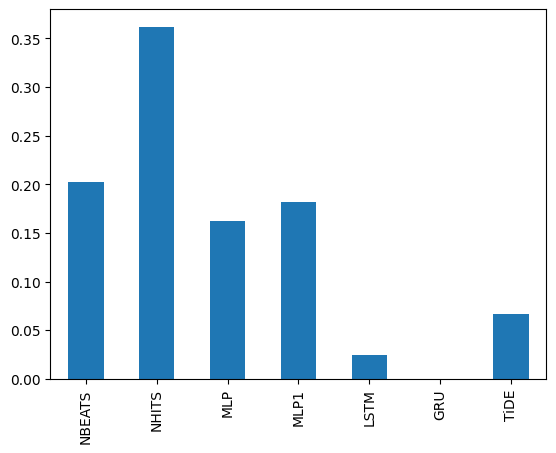

In [13]:
ensemble.uid_coefficient['M1000'].plot.bar()

Then, we refit the neural networks are get the test forecasts

In [ ]:
%%capture

nf.fit(df=train_df)

In [ ]:
%%capture

fcst = nf.predict(step_size=1)

In [16]:
fcst.query('unique_id=="M1"')

,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE
unique_id,,,,,,,,
M1,1994-09-30,2820.708008,2837.058838,2383.298828,2454.077393,2507.238525,2390.672607,2070.891602
M1,1994-10-31,2353.479248,2515.124512,2158.801270,2129.693848,2583.255859,2305.683838,2451.634033
M1,1994-11-30,2303.218750,2391.572754,2291.510254,2139.453857,2939.735107,2787.014160,1721.748047
M1,1994-12-31,2779.379883,2526.065918,2591.097412,2590.750244,2814.711182,2776.601318,2240.189941
M1,1995-01-31,2188.668457,2063.863525,2234.466553,1887.351929,2838.986328,2785.913818,1796.146118
M1,1995-02-28,1911.853271,2175.461670,1985.965088,1816.956787,2691.198242,2710.279541,2631.498779
M1,1995-03-31,2451.522461,2249.096436,2160.844971,1911.716309,2619.605469,2653.789551,1920.423096
M1,1995-04-30,1735.337402,1839.155762,1614.420044,1335.228027,2504.666992,2538.148926,2000.088135
M1,1995-05-31,1939.377686,2237.283691,2295.252930,2200.254150,2474.093994,2538.217285,3073.768555


In [17]:
fcst_ensemble = ensemble.predict(fcst.reset_index())

In [18]:
fcst[ensemble.alias] = fcst_ensemble.values

fcst.head()

,ds,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,MLpol
unique_id,,,,,,,,,
M1,1994-09-30,2820.708008,2837.058838,2383.298828,2454.077393,2507.238525,2390.672607,2070.891602,2633.876117
M1,1994-10-31,2353.479248,2515.124512,2158.801270,2129.693848,2583.255859,2305.683838,2451.634033,2346.027112
M1,1994-11-30,2303.218750,2391.572754,2291.510254,2139.453857,2939.735107,2787.014160,1721.748047,2263.482370
M1,1994-12-31,2779.379883,2526.065918,2591.097412,2590.750244,2814.711182,2776.601318,2240.189941,2581.755320
M1,1995-01-31,2188.668457,2063.863525,2234.466553,1887.351929,2838.986328,2785.913818,1796.146118,2066.855810


### 4. Evaluation

Finally, we compare all approaches

In [19]:
test_df = test_df.merge(fcst, on=['unique_id','ds'], how="left")

In [20]:
from neuralforecast.losses.numpy import smape
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(test_df, [smape], agg_by=['unique_id'])
evaluation_df

,metric,unique_id,NBEATS,NHITS,MLP,MLP1,LSTM,GRU,TiDE,MLpol
0,smape,M1,0.557906,0.565255,0.534834,0.545832,0.581718,0.577866,0.542147,0.548903
1,smape,M10,0.203316,0.192507,0.188595,0.183235,0.187489,0.188297,0.199679,0.192023
2,smape,M100,0.092943,0.084622,0.090799,0.095776,0.118231,0.119362,0.115861,0.091347
3,smape,M1000,0.011336,0.011435,0.013824,0.010244,0.010340,0.004813,0.006411,0.010227
4,smape,M1001,0.019537,0.019699,0.024808,0.019278,0.015281,0.007963,0.011028,0.018969
...,...,...,...,...,...,...,...,...,...,...
1423,smape,M995,0.007859,0.005549,0.012240,0.006474,0.026410,0.007585,0.010029,0.004580
1424,smape,M996,0.022319,0.022942,0.029199,0.026535,0.009965,0.007247,0.018761,0.024090
1425,smape,M997,0.081531,0.080787,0.077392,0.075628,0.065652,0.060192,0.080346,0.079193
1426,smape,M998,0.008090,0.007945,0.010729,0.010613,0.026844,0.018760,0.022788,0.008733


In [21]:
evaluation_df.drop(columns=['metric','unique_id']).mean().sort_values()

MLpol     0.126860
NBEATS    0.127429
NHITS     0.127779
MLP1      0.130285
MLP       0.130502
GRU       0.135435
TiDE      0.139523
LSTM      0.140415
dtype: float64